In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import re
import nltk
from nltk.tokenize import word_tokenize
import logging
from typing import Dict, List, Union, Tuple, Optional
import seaborn as sns
import matplotlib.pyplot as plt
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

c:\Users\manwi\anaconda3\envs\cuda_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Count:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("PyTorch Version:", torch.__version__)
else:
    print("No CUDA-compatible GPU found.")



CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce GTX 1660
CUDA Version: 12.1
PyTorch Version: 2.5.1+cu121


In [3]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
            
        return item

class BertSentimentClassifier(nn.Module):
    def __init__(self, n_classes=3):
        super(BertSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.classifier(output)

class SentimentAnalyzer:
    def __init__(self, 
                 max_length: int = 128,
                 batch_size: int = 16,
                 num_epochs: int = 3,
                 learning_rate: float = 2e-5,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.device = device
        self.model = None

    def validate_and_clean_ratings(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Validate and clean ratings column
        
        Args:
            df: Input DataFrame
            
        Returns:
            DataFrame with cleaned ratings
        """
        df = df.copy()
        
        # Check if 'rating' column exists
        if 'rating' not in df.columns:
            raise ValueError("Rating column not found in DataFrame")
            
        # Convert ratings to numeric, coerce errors to NaN
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
        
        # Print initial statistics
        print("\nRating Statistics Before Cleaning:")
        print(f"Total rows: {len(df)}")
        print(f"Missing ratings: {df['rating'].isna().sum()}")
        print("\nRating Distribution:")
        print(df['rating'].value_counts().sort_index())
        
        # Filter invalid ratings
        invalid_mask = ~df['rating'].between(1, 5)
        invalid_count = invalid_mask.sum()
        if invalid_count > 0:
            print(f"\nFound {invalid_count} invalid ratings (not between 1-5)")
            
        # Create clean ratings mask
        valid_mask = (
            df['rating'].between(1, 5) &  # Rating between 1-5
            df['rating'].notna() &        # Rating is not NaN
            df['review_text'].notna()     # Review text is not NaN
        )
        
        # Apply cleaning
        df_cleaned = df[valid_mask].copy()
        
        # Print cleaning results
        print("\nCleaning Results:")
        print(f"Original rows: {len(df)}")
        print(f"Rows after cleaning: {len(df_cleaned)}")
        print(f"Removed rows: {len(df) - len(df_cleaned)}")
        
        return df_cleaned

    def convert_ratings_to_sentiment(self, rating: float) -> int:
        """
        Convert 1-5 rating to sentiment class
        
        Args:
            rating: Rating value (1-5)
            
        Returns:
            0 for negative (1-2)
            1 for neutral (3)
            2 for positive (4-5)
        """
        if pd.isna(rating):
            raise ValueError("Rating cannot be NaN")
            
        if not 1 <= rating <= 5:
            raise ValueError(f"Rating {rating} is not between 1 and 5")
            
        if rating <= 2:
            return 0  # Negative
        elif rating == 3:
            return 1  # Neutral
        else:
            return 2  # Positive

    def prepare_data(self, df: pd.DataFrame) -> Tuple[List[str], np.ndarray]:
        """
        Prepare data for BERT model
        """
        print("\nPreparing data...")
        
        # Clean and validate ratings
        df_cleaned = self.validate_and_clean_ratings(df)
        
        # Convert ratings to sentiment labels
        df_cleaned['sentiment'] = df_cleaned['rating'].apply(self.convert_ratings_to_sentiment)
        
        # Get texts and labels
        texts = df_cleaned['review_text'].tolist()
        labels = df_cleaned['sentiment'].values
        
        return texts, labels

    def train(self, texts_train: List[str], y_train: np.ndarray) -> None:
        """
        Train the BERT model
        """
        print("\nTraining model...")
        
        # Create dataset and dataloader
        train_dataset = SentimentDataset(
            texts=texts_train,
            labels=y_train,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
        
        # Initialize model
        self.model = BertSentimentClassifier().to(self.device)
        
        # Initialize optimizer and scheduler
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        total_steps = len(train_loader) * self.num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )
        
        # Training loop
        for epoch in range(self.num_epochs):
            print(f'\nEpoch {epoch + 1}/{self.num_epochs}')
            
            self.model.train()
            total_loss = 0
            
            for batch in train_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            print(f'Average loss: {avg_loss:.4f}')

    def evaluate(self, texts_test: List[str], y_test: np.ndarray) -> Dict:
        """
        Evaluate the BERT model
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
            
        print("\nEvaluating model...")
        
        test_dataset = SentimentDataset(
            texts=texts_test,
            labels=y_test,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size)
        
        self.model.eval()
        predictions = []
        probabilities = []
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())
        
        predictions = np.array(predictions)
        probabilities = np.array(probabilities)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, predictions,
                                 target_names=['Negative', 'Neutral', 'Positive']))
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, predictions)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Neutral', 'Positive'],
                   yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return {
            'confusion_matrix': cm,
            'predictions': predictions,
            'probabilities': probabilities
        }

    def predict(self, text: str) -> Tuple[str, Dict[str, float]]:
        """
        Predict sentiment using the BERT model
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
            
        self.model.eval()
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            prediction = torch.argmax(outputs, dim=1)
        
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        sentiment = sentiment_map[prediction.item()]
        prob_dict = {sentiment_map[i]: prob.item() 
                    for i, prob in enumerate(probabilities[0])}
        
        return sentiment, prob_dict


Preparing data...

Rating Statistics Before Cleaning:
Total rows: 1597
Missing ratings: 420

Rating Distribution:
rating
1.0     42
2.0     34
3.0    124
4.0    236
5.0    741
Name: count, dtype: int64

Found 420 invalid ratings (not between 1-5)

Cleaning Results:
Original rows: 1597
Rows after cleaning: 1177
Removed rows: 420

Training model...


c:\Users\manwi\anaconda3\envs\cuda_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3
Average loss: 0.5376

Epoch 2/3
Average loss: 0.3481

Epoch 3/3
Average loss: 0.2404

Evaluating model...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.40      0.52        15
     Neutral       0.57      0.48      0.52        25
    Positive       0.93      0.98      0.95       196

    accuracy                           0.89       236
   macro avg       0.75      0.62      0.67       236
weighted avg       0.88      0.89      0.88       236



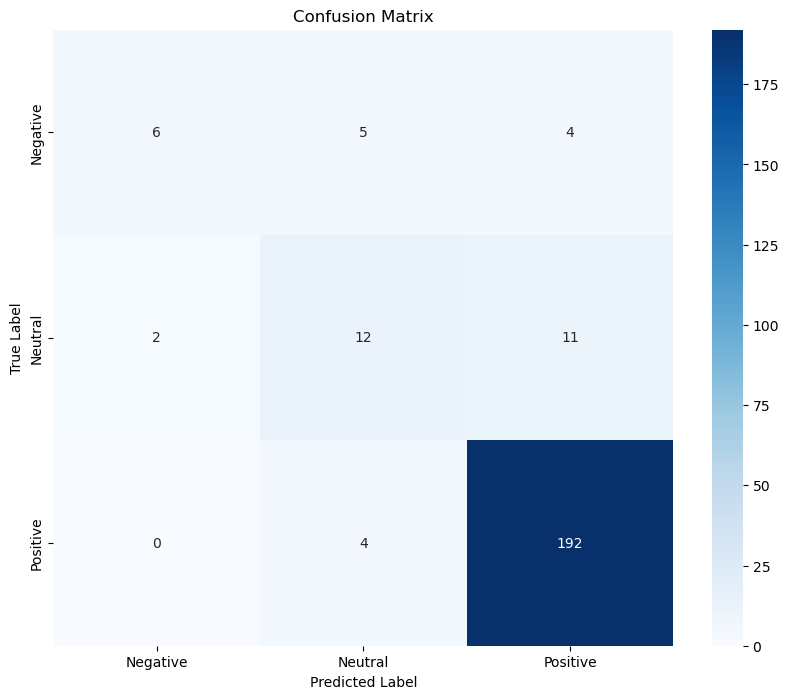


Predicted sentiment: Positive
Class probabilities:
Negative: 0.01
Neutral: 0.02
Positive: 0.97


In [4]:
# Load your data
df = pd.read_csv('../data/7817_1.csv') # Source: https://www.kaggle.com/datasets/yasserh/amazon-product-reviews-dataset/data
df = df.rename(columns={'reviews.text': 'review_text', 'reviews.rating': 'rating'})

# Load your data and GloVe embeddings
glove_model = {}
with open('../assets/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector


# Initialize analyzer with BERT
analyzer = SentimentAnalyzer(
    max_length=128,
    batch_size=16,
    num_epochs=3,
    learning_rate=2e-5
)

# Prepare data
texts, labels = analyzer.prepare_data(df)

# Split data
texts_train, texts_test, y_train, y_test = train_test_split(
    texts, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Train model
analyzer.train(texts_train, y_train)

# Evaluate model
metrics = analyzer.evaluate(texts_test, y_test)

# Make predictions
text = "This product is amazing! I love it!"
sentiment, probabilities = analyzer.predict(text)
print(f"\nPredicted sentiment: {sentiment}")
print("Class probabilities:")
for sentiment, prob in probabilities.items():
    print(f"{sentiment}: {prob:.2f}")

In [9]:
# Sample Review
sample_review = "This product was ok. Not great, not terrible."
sentiment, probabilities = analyzer.predict(sample_review)
print(sentiment)

Positive
